In [3]:
import numpy as np
from PIL import Image
from sklearn.decomposition import PCA, KernelPCA
import sklearn
import matplotlib.pyplot as plt

# Introduction

In this notebook we are going to learn about denoisifying images using PCA. We begin with a simple example of noisy linear observations. We then introduce the fashion MNIST data-set, where we will take some images and artificially add noise. You must then submit a set of exercises related to denoisifying the images using PCA and Kernel PCA.

To try and understand how PCA can help us denoisify, consider the following plot:

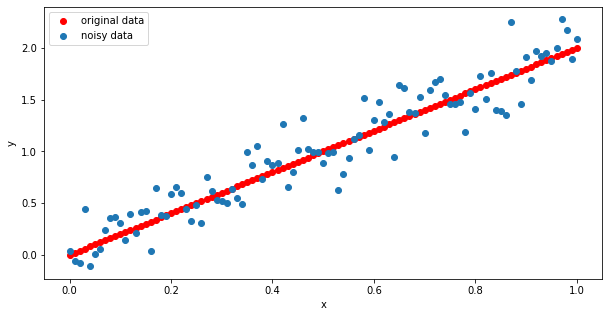

In [4]:
# original data
x = np.linspace(0, 1, 101)
y = 2 * x

# add noise to data
y_noisy = y + np.random.normal(0, 0.2, size = x.shape)

fig, ax = plt.subplots(nrows = 1, ncols = 1)
fig.set_figheight(5)
fig.set_figwidth(10)

ax.scatter(x, y, color = 'r', label = 'original data')
ax.scatter(x, y_noisy, label = 'noisy data')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()

The plot above shows simple linear data, corrupted by a small amount of Gaussian noise. Can you see why a 1-dimensional representation of the data can help in getting rid of the noise? If we project every noisy data point to the line $y = 2x$, we recover out original data exactly! This is the idea behind PCA denoisifying. This is a simple example, so we are going to explore a more interesting one:

# Denoisify Fashion-MNIST

We will now try to denoisify data from the fashion MNIST data-set. This is an analogous data set to the MNIST hand written digits set, however it is made up of pictures of different types of clothing. It consists of 10 different labels: t-shirt (0), trouser (1), pullover (2), dress (3), coat (4), sandal (5), shirt (6), sneaker (7), bag (8), ankle boot (9). The code below downloads 5022 images from the data-set and splits into a training and testing data-set. We will then visualize the test set. 

In [5]:
X = np.genfromtxt('fashion-mnist_train.csv', delimiter=',')

Y = X[1:, 0]
X_train = X[21:, 1:]
X_test = X[1:21, 1:]

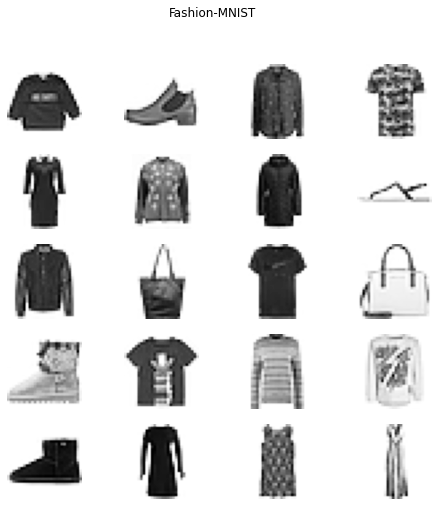

In [6]:
def plot_images(X, title):
    # we use this function to plot the training images
    fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(8, 8))
    for img, ax in zip(X, axs.ravel()):
        ax.imshow(img.reshape((28, 28)), cmap="Greys")
        ax.axis("off")
    fig.suptitle(title, fontsize=12)

plot_images(X_test, 'Fashion-MNIST')

We will artificially add noise to the images and display them:

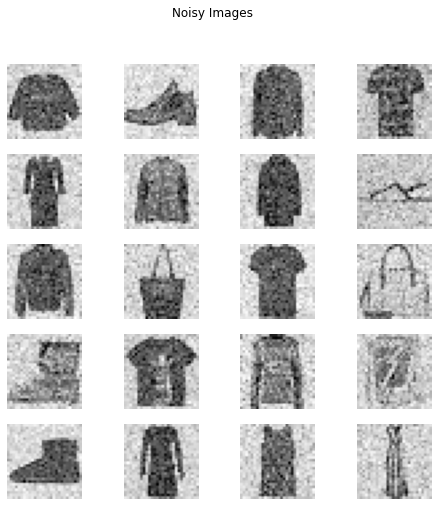

In [7]:
X_noisy = X_test + np.random.normal(loc = 0, scale = 40, size = X_test.shape)

plot_images(X_noisy, 'Noisy Images')

To denoisify, we will use the training set to *learn* a low-dimensional space that represents our data, which can be used to remove noise from *similar* images. We can see an example here: https://scikit-learn.org/stable/auto_examples/applications/plot_digits_denoising.html where we use a data-set of uncorrupted digits to remove the noise from corrupted digits.

Note that we treat each image as a flat vector with 784 features. Ideally we want to take bigger advantages of known structure in the images, for example, when flattening the image, we lose a lot of spatial structure (a pixel is closely related to all those around it)!. As an example, the following paper: https://www.researchgate.net/publication/267228169_PCA_based_image_denoising adds filters to the processes to achieve much better results. 

Other examples of exploiting image structure will be introduced in Module 21 (Convolutional Neural Networks).

# Exercises

The following code will train a PCA model on the training set. It then uses the learned principal components to project the noisy data into a lower dimensional representation, and reconstructs them. We hope this will denoisify the image. However, as you see, it will no be very good. The noise will be gone but the images will not resemble the original. Try increasing the number of principal components to fix this! Play around with it until you get a good denoisification. Answer the following questions:

1. What is the behavior of the reconstructed images as you include more components?

As we include more principal components in the reconstruction process, the reconstructed images tend to become more faithful to the original images. This is because higher-dimensional representations can capture more variability in the data, including both signal and noise components. Therefore, increasing the number of components generally leads to better denoising performance.

However, there's a trade-off involved. Using too many components can lead to overfitting and the reconstruction of noise rather than signal. So, the challenge lies in finding the optimal number of components that effectively denoises the images without introducing too much noise or losing too much information.

2. What is the best number of components for denoisifying this particular test set?

To determine the best number of components for denoising this particular test set, we typically need to experiment with different numbers of components and evaluate the quality of the reconstructed images. This evaluation can be subjective or quantitative, depending on the specific requirements of your task.

One common approach is to visually inspect the reconstructed images and compare them to the original images. Look for the point where the reconstructed images start resembling the originals while also removing most of the noise. Additionally, you can use metrics such as mean squared error (MSE) or peak signal-to-noise ratio (PSNR) to quantitatively assess the reconstruction quality.

We can see below in the plots,MSE goes down till number_of_principal_components = 400 but the variance explained only increases slightly.We can choose components between 140-400 since they begin to look the same till 400.

Total variance explained by %d components: %f 150 0.9396117540288949


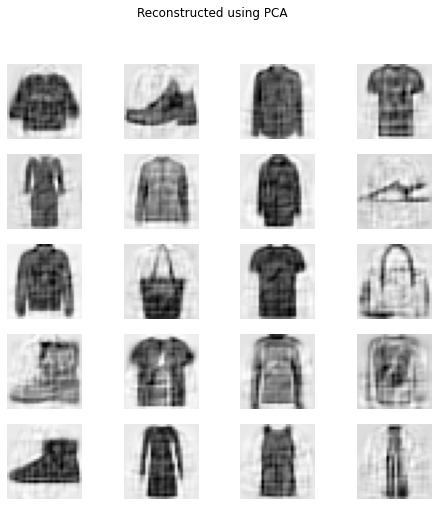

In [23]:
# fit a PCA model
number_of_principal_components = 150
pca = PCA(n_components = number_of_principal_components)
pca.fit(X_train)

var = pca.explained_variance_ratio_
var_explained = np.zeros(number_of_principal_components)
for i in range(number_of_principal_components):
    var_explained[i] = sum(var[:i+1])

print("Total variance explained by %d components: %f", number_of_principal_components, var_explained[-1])


# transform the noisy data into a lower dimensional representation and then back to a high dimensional one
X_reconstructed_pca = pca.inverse_transform(pca.transform(X_noisy))

# plot the denoisified images
plot_images(X_reconstructed_pca, 'Reconstructed using PCA')

In [24]:
from sklearn.metrics import mean_squared_error
mses = []
psnrs = []
var_exp = []
x_axis = range(10,400,10)
for number_of_principal_components in x_axis:
    pca = PCA(n_components = number_of_principal_components)
    pca.fit(X_train)
    var = pca.explained_variance_ratio_
    var_explained = np.zeros(number_of_principal_components)
    for i in range(number_of_principal_components):
        var_explained[i] = sum(var[:i+1])

    # transform the noisy data into a lower dimensional representation and then back to a high dimensional one
    X_reconstructed_pca = pca.inverse_transform(pca.transform(X_noisy))
    mse = mean_squared_error(X_noisy, X_reconstructed_pca.reshape(X_noisy.shape))
    mses.append(mse)

    # Calculate PSNR
    max_pixel_value = np.max(X_noisy)
    psnr = 20 * np.log10(max_pixel_value / np.sqrt(mse))
    psnrs.append(psnr)
    
    #variance explained
    var_exp.append(var_explained[-1])


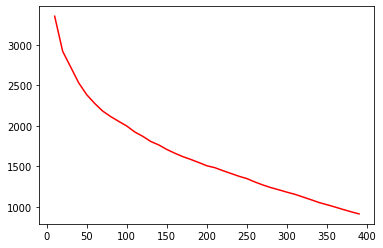

In [25]:
plt.plot(x_axis, mses, label='mse', color='red')

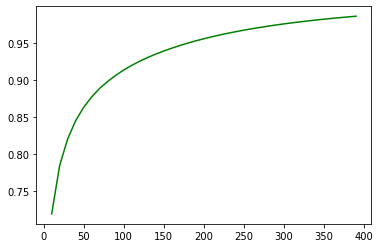

In [26]:
plt.plot(x_axis, var_exp, label='var', color='green')

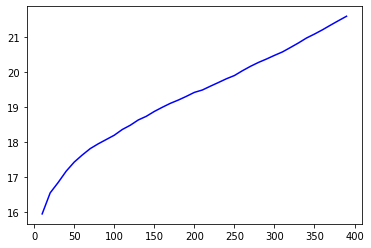

In [27]:
plt.plot(x_axis, psnrs, label='mse', color='blue')

3. Repeat the exercise above but using Kernel PCA instead. Are you able to achieve better results?
No the results are grainy and ghostly

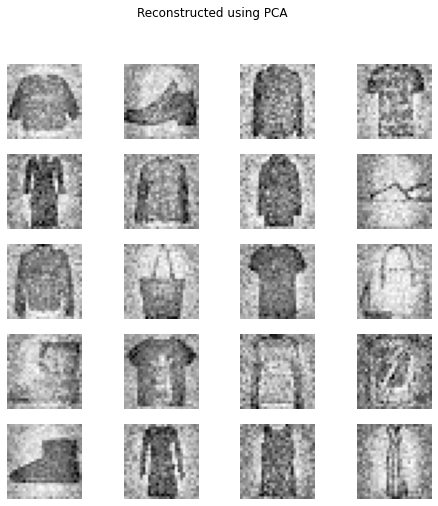

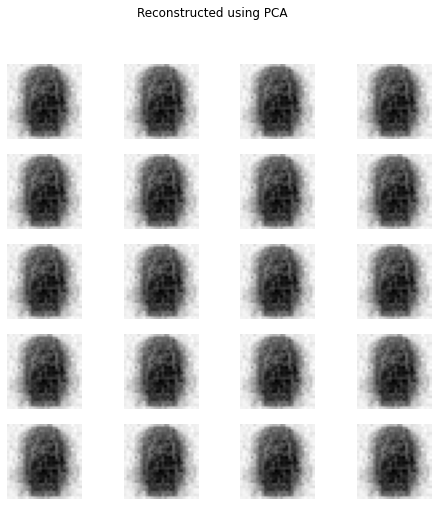

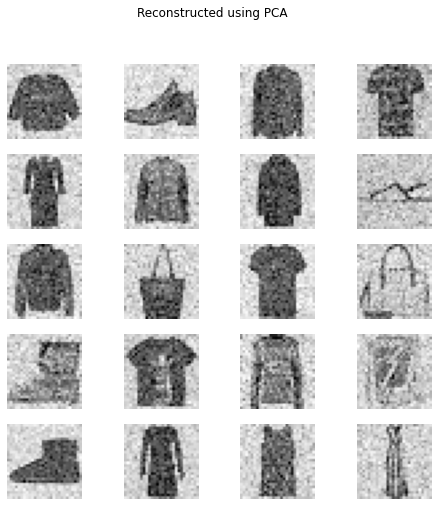

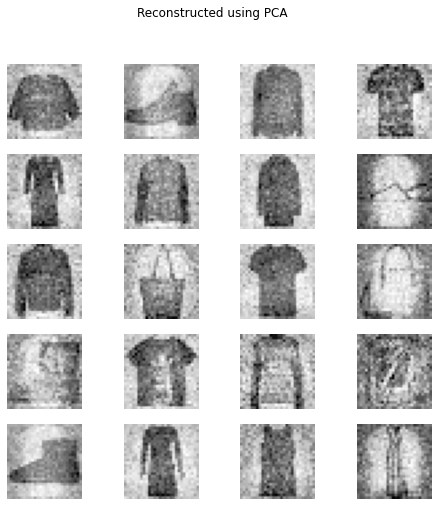

In [28]:
from sklearn.decomposition import KernelPCA
number_of_principal_components = 150

kpca_linear = KernelPCA(n_components = number_of_principal_components, kernel = "linear", fit_inverse_transform=True)
kpca_rbf = KernelPCA(n_components = number_of_principal_components, kernel = "rbf", fit_inverse_transform=True)
kpca_poly = KernelPCA(n_components= number_of_principal_components, kernel= "poly", fit_inverse_transform=True)
kpca_cos = KernelPCA(n_components= number_of_principal_components, kernel= "cosine", fit_inverse_transform=True)

X_linear = kpca_linear.fit_transform(X_noisy)
X_rbf = kpca_rbf.fit_transform(X_noisy)
X_poly = kpca_poly.fit_transform(X_noisy)
X_cos = kpca_cos.fit_transform(X_noisy)

for kpca in [kpca_linear, kpca_rbf, kpca_poly, kpca_cos]:
    # transform the noisy data into a lower dimensional representation and then back to a high dimensional one
    X_reconstructed_pca = kpca.inverse_transform(kpca.fit_transform(X_noisy))

    # plot the denoisified images
    plot_images(X_reconstructed_pca, 'Reconstructed using PCA')

4. Finally, we note that the shoes are not always reconstructed well. Assuming you had labelled images, can you think of a way of improving the denoisification process?


If you have labeled images and you notice that certain classes of objects, such as shoes, are not always reconstructed well during the denoising process, you can consider incorporating this additional information into your denoising pipeline to improve the reconstruction quality specifically for shoes. Here are a few ways you could potentially achieve this:

Class-specific Denoising: Train separate denoising models or pipelines for different classes of objects. For example, you could train one denoising model specifically for shoes using only labeled shoe images. This would allow the model to learn features that are specific to shoes and potentially improve reconstruction quality for this class.

Class-aware Feature Extraction: If you're using a feature-based denoising approach (e.g., PCA), you could incorporate class labels into the feature extraction step. For example, you could perform PCA separately for each class of objects (e.g., shoes, shirts, pants) to learn class-specific principal components. Then, during the reconstruction step, you could use the appropriate class-specific principal components based on the label of each image.

Data Augmentation: Augment your dataset of labeled shoe images with various transformations (e.g., rotation, translation, scaling) to increase its diversity and improve generalization. This can help the denoising model learn more robust features and improve reconstruction quality for shoes.